# English Premier League Match Outcome Prediction

## Introduction

### Problem Contextualization

Predicting the outcome of sports matches has always been a challenging problem in the field of artificial intelligence and machine learning. There are many variables that go into making a prediction, such as team performance, player conditions, and external factors.

This project focuses on predicting the outcome of specific matches in the English Premier League (PL). The PL is arguably the most competitive football league in the world, attracting a massive pool of talented players. The season runs from August until May, where 20 teams compete in a league format to accumulate the most points throughout their 38-game campaign and lift the prestigious title.

### Motivation for AI Use

The primary motivation for employing AI in predicting match outcomes is to harness the power of data-driven decision-making. Traditional methods of forecasting match results, often based on expert opinion or simple statistics, can be subjective and limited in scope. Machine learning models, particularly ensemble methods which we'll use in this project, can leverage vast amounts of historical data to identify complex patterns and interactions between variables, providing more accurate and reliable predictions. These models can be particularly useful for fans, analysts, and sport bettors by increasing their capacity to make informed predictions.


## Dataset

The dataset used in this project is comprised of the historical data of PL matches from the 1993 season up until the 2023 season, stored in a CSV file named `premier-league-matches.csv`. 

This dataset was downloaded from Kaggle and can be found [here](https://www.kaggle.com/datasets/evangower/premier-league-matches-19922022?select=premier-league-matches.csv).

The dataset includes the following attributes:

- `index`: The unique ID for the match
- `Season_End_Year`: The season in which the match was played
- `Wk`: The matchweek in which the match was played
- `Date`: The date on which the match was played
- `Home`: The home team
- `Away`: The away team
- `HomeGoals`: The number of goals scored by the home team
- `AwayGoals`: The number of goals scored by the away team
- `FTR`: Full-time result (H for home win, D for draw, A for away win)


## Requirements
To run the code, you need to have the following libraries installed:

- **pandas**: For data manipulation and analysis
- **scikit-learn (sklearn)**: For machine learning models and utilities
- **xgboost**: For the eXtreme Gradient Boosting algorithm
- **joblib**: For saving and loading trained models and encoders

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, confusion_matrix
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary Analysis

### Data Cleansing

Like any project, the first and most important step is to clean the data. Initial data cleansing involved converting the `date` column to a datetime format. The second step was to encode the categorical variables `Home` and `Away` into numeric format which is necessary for machine learning algorithms.

In [3]:
# load data
file_path = 'data/premier-league-matches.csv'
matches = pd.read_csv(file_path)

# clean data types and create new features
matches["date"] = pd.to_datetime(matches["Date"])
matches["h/a"] = matches["Home"].astype("category").cat.codes
matches["opp"] = matches["Away"].astype("category").cat.codes
matches["day"] = matches["date"].dt.dayofweek
matches["target"] = (matches["FTR"] == "H").astype("int")

### Feature Engineering

Several new features were engineered to capture important aspects of match dynamics:

- `day`: the day of the week the match was played
- `h/a`: encoded representation of home team
- `opp`: encoded representation of away team
- `target`: binary target variable indicating a home win (**1**) or not (**0**).
- `home_form` and `away_form`: rolling averages of recent performance for the home and away teams, respectively, based on the last five matches

In [4]:
# add recent form feature
matches['home_form'] = matches.groupby('Home')['target'].transform(lambda x: x.rolling(5, min_periods=1).mean())
matches['away_form'] = matches.groupby('Away')['target'].transform(lambda x: x.rolling(5, min_periods=1).mean())

In [5]:
# calculate h2h performance stats over time
def calculate_dynamic_h2h_stats(matches):
    matches = matches.sort_values(by='date')
    h2h_wins, h2h_draws, h2h_losses = [], [], []
    
    # Initialize a dictionary to store past match results
    past_results = {}

    for index, row in matches.iterrows():
        home_team = row['Home']
        away_team = row['Away']
        match_date = row['date']
        
        if (home_team, away_team) not in past_results:
            past_results[(home_team, away_team)] = {'wins': 0, 'draws': 0, 'losses': 0}
        
        # Append the current stats before updating
        h2h_wins.append(past_results[(home_team, away_team)]['wins'])
        h2h_draws.append(past_results[(home_team, away_team)]['draws'])
        h2h_losses.append(past_results[(home_team, away_team)]['losses'])
        
        # Update the past results
        if row['FTR'] == 'H':
            past_results[(home_team, away_team)]['wins'] += 1
        elif row['FTR'] == 'D':
            past_results[(home_team, away_team)]['draws'] += 1
        elif row['FTR'] == 'A':
            past_results[(home_team, away_team)]['losses'] += 1
    
    matches['h2h_wins'] = h2h_wins
    matches['h2h_draws'] = h2h_draws
    matches['h2h_losses'] = h2h_losses
    
    return matches

matches = calculate_dynamic_h2h_stats(matches)

Fortunately, we do not have any NA values in the datasets and the features added so we don't have to take any measures to handle them but there could potentially be in the future so it's always a good idea to make sure.

In [6]:
# check for NA values
print(matches.isna().sum())

Season_End_Year    0
Wk                 0
Date               0
Home               0
HomeGoals          0
AwayGoals          0
Away               0
FTR                0
date               0
h/a                0
opp                0
day                0
target             0
home_form          0
away_form          0
h2h_wins           0
h2h_draws          0
h2h_losses         0
dtype: int64


### Exploratory Data Analysis

To build an idea of what the data looks like we can quickly plot some of the most important observations about the dataset.

Percentage of Home Wins: 45.89%
Percentage of Draws: 25.75%
Percentage of Away Wins: 28.36%


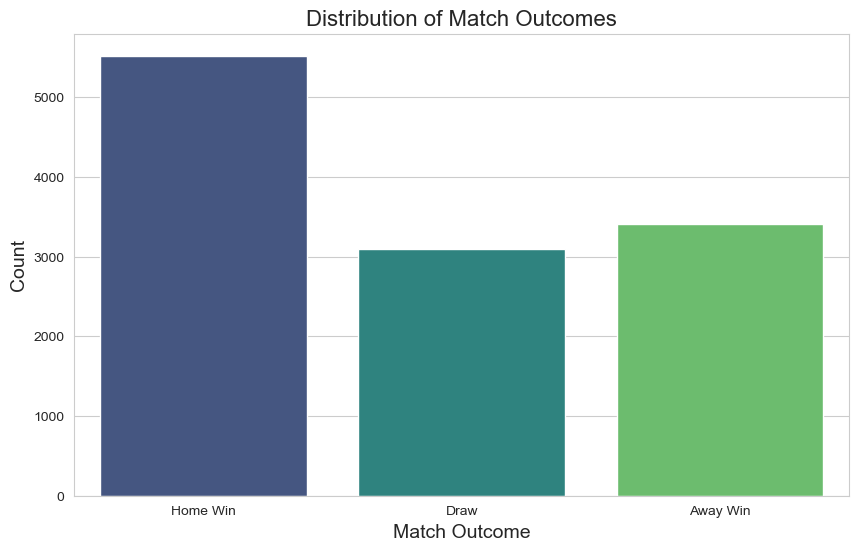

In [7]:
# calculate match outcome distribution
home_wins = sum(matches['FTR'] == 'H')
draws = sum(matches['FTR'] == 'D')
away_wins = sum(matches['FTR'] == 'A')
total_matches = len(matches)

home_win_pct = (home_wins / total_matches) * 100
draw_pct = (draws / total_matches) * 100
away_win_pct = (away_wins / total_matches) * 100

print(f"Percentage of Home Wins: {home_win_pct:.2f}%")
print(f"Percentage of Draws: {draw_pct:.2f}%")
print(f"Percentage of Away Wins: {away_win_pct:.2f}%")

# plot distribution of match outcomes
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='FTR', data=matches, palette='viridis', hue='FTR')
plt.title('Distribution of Match Outcomes', fontsize=16)
plt.xlabel('Match Outcome', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=[0, 1, 2], labels=['Home Win', 'Draw', 'Away Win'])
plt.show()

The percentage of home wins is far greater than the percentage of draws or losses, which makes a lot of sense. Teams usually feel more comfortable playing in their own stadium in front of their own fans. Historically speaking, the home team has won 45.89% of the time. The percent of games that end in draws and away wins/home losses is 25.75% and 28.36% respectively.

Looking at the recent form stats that we calculated previously, below we can see a distribution of recent form for home and away teams across the dataset. Recent form was calculated as a 5 match rolling average, so we have 5 general groups. We see that there is a quite convincing normal distribution, meaning teams are more likely to have a 2W/3L or 3W/2L split than a 0W/5L or 5W/0L split.

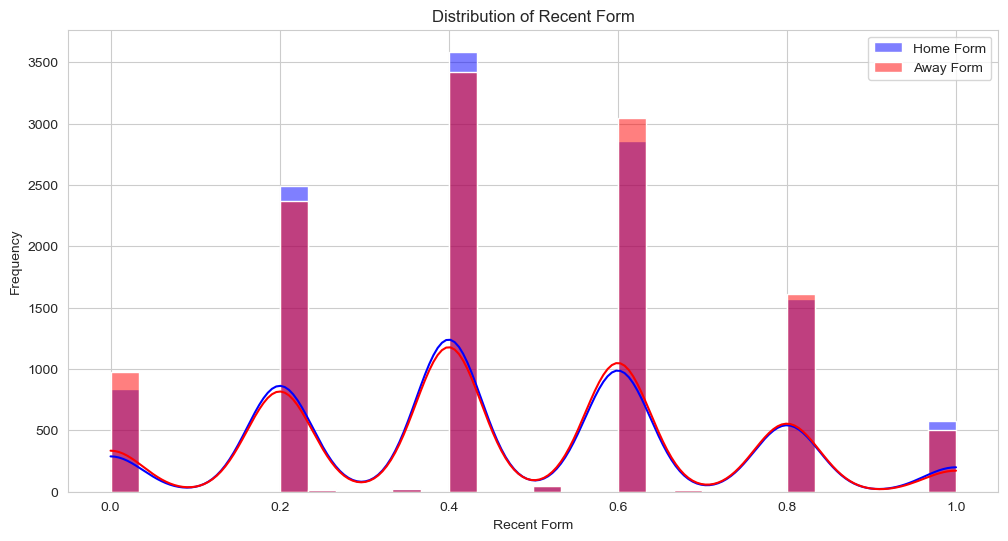

In [8]:
# visualize recent form
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(matches['home_form'], kde=True, bins=30, label='Home Form', color='blue')
sns.histplot(matches['away_form'], kde=True, bins=30, label='Away Form', color='red')
plt.title('Distribution of Recent Form')
plt.xlabel('Recent Form')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The pair plot below provides a visual representation of the relationships between pairs of features in the dataset. It also shows the distribution of each feature along the diagonal. This visualization is helpful for understanding interactions between features and how they relate to the target variable. The selected features are `h/a`, `opp`, `day`, `home_form`, `away_form`, and `target`.

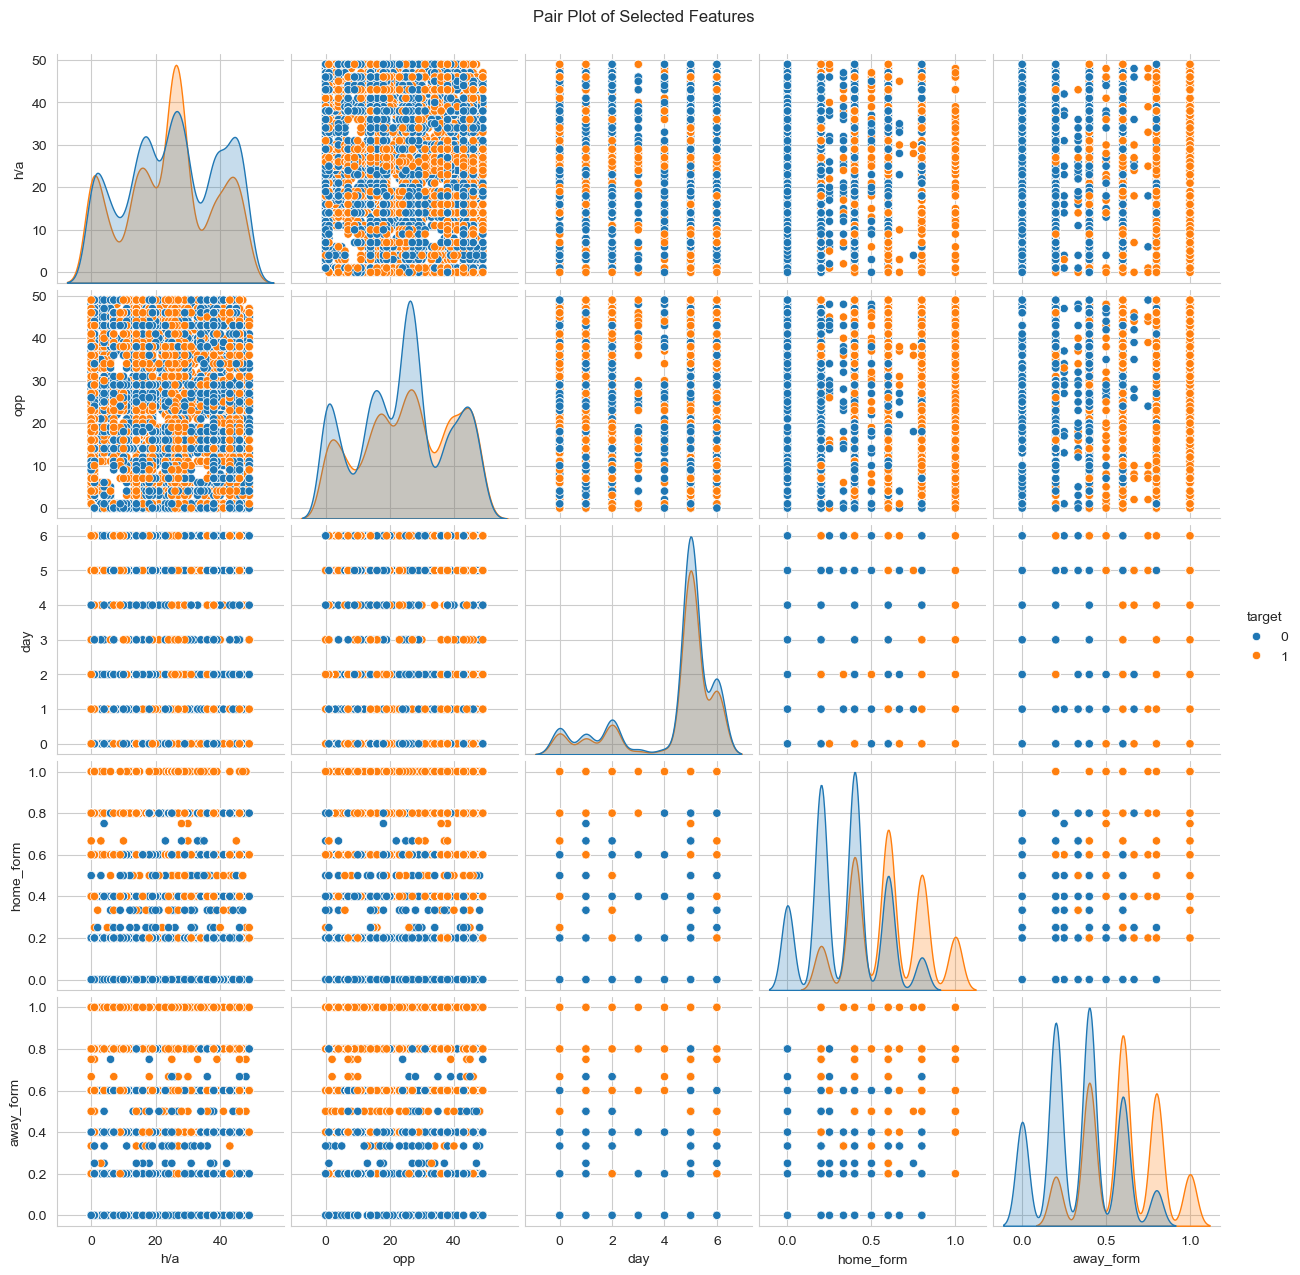

In [9]:
# pair plot of selected features
subset_features = ["h/a", "opp", "day", "home_form", "away_form", "target"]
sns.pairplot(matches[subset_features], hue='target')
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

To understand the pair plot, the diagonal elements display the distribution (density plots) of each feature. The distributions are separated by the target variable, with different colors representing different classes (0 and 1). The off-diagonal elements display scatter plots of feature pairs. Each scatter plot shows the relationship between two features, with points colored by the target variable.

The distributions for `home_form` and `away_form` show multiple peaks, indicating that teams have varying performance levels. For when the match takes place, `day` shows a clear preference for matches towards the end of the week. The scatter plots show that there are no strong linear relationships between most feature pairs, but some clustering can be observed based on the target variable. For example, certain clusters in the `home_form` vs `away_form` scatter plot suggest that teams with certain home performance levels might also have corresponding away performance levels. Different colors in the scatter plots help visualize how the target variable (win/loss) is distributed across the feature space. Some features like `home_form` and `away_form` show better separation between the classes, suggesting these features are useful in predicting the target variable.

## Building the Model

### Methodology

In terms of methodology, we will be using stacking classifier. This ensemble method combines multiple machine learning models to improve predictive performance. The following models were used:

- **Random Forest Classifier**
    
    * Random Forest is an ensemble method that builds multiple decision trees and merges their outputs to improve accuracy and control overfitting, while providing insight into the importance of specific features. This model is robust to noise which is another reason why it was selected.
    
- **XGBoost Classifier**: 

    * XGBoost (Extreme Gradient Boosting) is an algorithm known for its high performance in classification task. It includes regularization parameters that help in preventing overfitting, making it a robust model like Random Forest. XGBoost is also designed to be efficient and scalable making it easier to handle large datasets and complex models which are great for further exploration.
    
- **Logistic Regression**:

    * Logistic Regression is going to be used as the final estimator in the stacking classifier to combine the predictions of the base models, the Random Forest and XGBoost. It is a quite simple and easily interpretable model that can effectively weigh the outputs from the base models and produce a final prediction.

These three models work very well together as they each bring their own strength to the table. It's the equivalent of having three unique people observing something rather than just one. 

### Training the Model

For the train-test split, we will be using an approximate 80/20 split. Using the first 24 seasons from 1993-2017 as the training set and the remaining 6 seasons from 2018-2023 as the test set. Our predictors will be `h/a`, `opp`, `day`, `home_form`, `away_form`, `h2h_wins`, `h2h_draws`, and `h2h_losses`. 

Addressing the initial stages of the model, I experimented with a Random Forest without hypertuning and it returned a ~57% accuracy with just `h/a`, `opp`, and `day`. Then I added `home_form`, `away_form`, `h2h_draws`, `h2h_draws`, and `h2h_losses` as well as XGBoost and Logistic Regression to hopefully increase the accuracy of the model.

In [10]:
# train-test split
train = matches[matches["date"] < '2017-07-01']
test = matches[matches["date"] >= '2017-07-01']
predictors = ["h/a", "opp", "day", "home_form", "away_form","h2h_wins", "h2h_draws", "h2h_losses"]

### Hyperparameter Tuning

In this section, we perform hyperparameter tuning for a Random Forest classifier using Grid Search with cross-validation. The goal of hyperparameter tuning is to find the optimal combination of hyperparameters for our model to improve its performance.

We start by defining a parameter grid, which is a dictionary where the keys are the hyperparameters we want to tune, and the values are lists of possible values for those hyperparameters. Then we initialize a Random Forest classifier with some fixed parameters and a predefined `random_state` for reproducibility. Then we can use `GridSearchCV` to perform a search over the parameter grid we defined above. The last step is to fit the model and retrieve the best combination of hyperparameters found during the grid search.

Our target for the models trained will be either a win or loss defined as **1** and **0** respectively.

In [11]:
# hyperparameter tuning for RF
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=1, class_weight='balanced')
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(train[predictors], train['target'])
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END bootstrap=True,

### XGBoost

Now that we have the Random Forest, we can move onto the XGBoost. Using the library downloaded, we can simply initiate an instance of the XGBoost classifier. Then we can go ahead and fit the model using the same predictors and target we used for the Random Forest.

In [12]:
# train XGBoost
xgb = XGBClassifier()
xgb.fit(train[predictors], train['target'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Stacking Classifier

Now that we have both the Random Forest and the XGBoost, we'll use a stacking classifier with Logistic Regression as the final estimator to generate our final model.

In [13]:
# stacking classifier
estimators = [
    ('rf', best_rf),
    ('xgb', xgb)
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(train[predictors], train['target'])

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       min_samples_leaf=4,
                                                       random_state=1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegression())

### Learning Curves

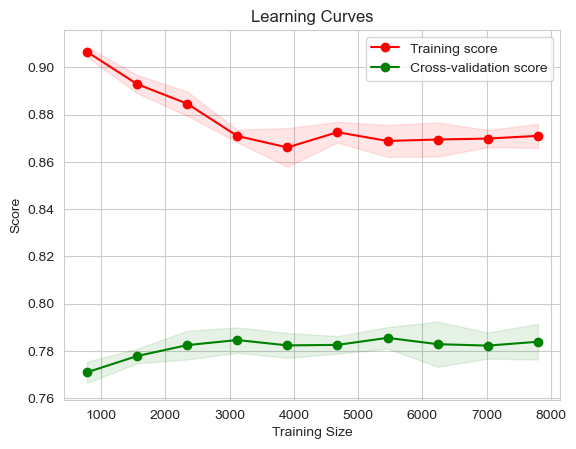

In [31]:
from sklearn.model_selection import learning_curve

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(stacking_clf, train[predictors], train['target'], cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()

### Cross-Validation

It's imperative to evaluate the model before we save it or make any predictions with it. For this we'll use cross-validation. We'll do a 10-fold cross-validation, the results are listed below.

In [14]:
# cross-validation
cv_scores = cross_val_score(stacking_clf, train[predictors], train['target'], cv=10)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")

Cross-Validation Scores: [0.78871795 0.77128205 0.78461538 0.78153846 0.78461538 0.77538462
 0.79876797 0.77720739 0.78952772 0.78542094]
Mean CV Score: 0.7837077870794503


The scores range from 77.12% to 79.88% with the mean score being 78.37%. These results indicate that the stacking classifier performs well on this dataset, with a consistent level of accuracy across different folds.

## Model Performance

Now that we have our cross-validation results we can save the model and make predictions and assess the accuracy, precision, as well as the whole classification report. The results are below.

In [15]:
# model path
model_path = 'models/stacking_model.pkl'

In [16]:
# dump model
joblib.dump(stacking_clf, model_path)

# save encoders
home_encoder = LabelEncoder().fit(matches['Home'])
away_encoder = LabelEncoder().fit(matches['Away'])
joblib.dump(home_encoder, 'models/home_encoder.pkl')
joblib.dump(away_encoder, 'models/away_encoder.pkl')

['models/away_encoder.pkl']

In [17]:
# loading model
stacking_clf = joblib.load(model_path)

In [18]:
# make predictions
preds = stacking_clf.predict(test[predictors])

### Performance Metrics

The classification report provides a great set of metrics to evaluate the overall model performance. The table and bar chart below provide the results from our model.

              precision    recall  f1-score      support
Loss/Draw      0.805534  0.829770  0.817473  1263.000000
Win            0.780388  0.751229  0.765531  1017.000000
accuracy       0.794737  0.794737  0.794737     0.794737
macro avg      0.792961  0.790500  0.791502  2280.000000
weighted avg   0.794318  0.794737  0.794304  2280.000000


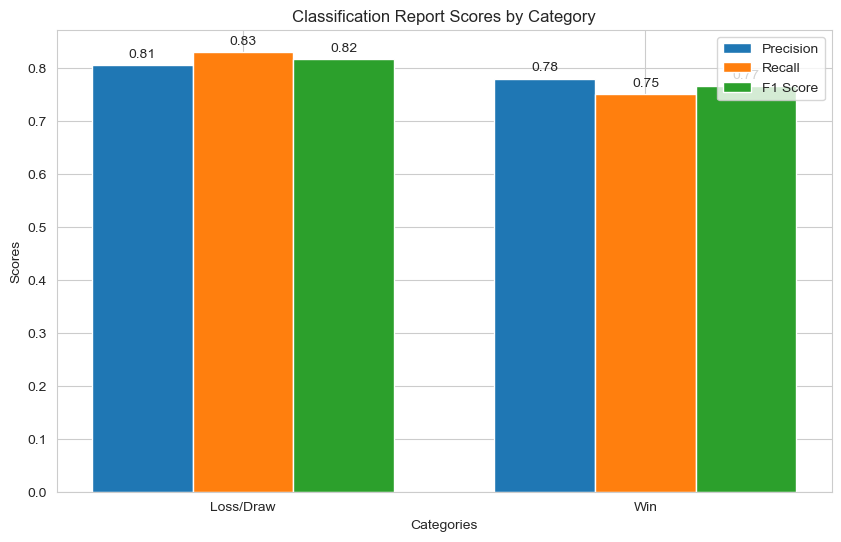

In [19]:
# generate classification report
report = classification_report(test["target"], preds, target_names=['Loss/Draw', 'Win'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# extract precision, recall, and f1-score for 'Loss/Draw' and 'Win'
precision = report_df.loc[['Loss/Draw', 'Win'], 'precision'].values
recall = report_df.loc[['Loss/Draw', 'Win'], 'recall'].values
f1_score = report_df.loc[['Loss/Draw', 'Win'], 'f1-score'].values
categories = ['Loss/Draw', 'Win']

# print classification report
print(report_df)

# plot classification report
x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

ax.set_xlabel('Categories')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Scores by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
plt.show()

The first metric, **precision**, answers the question of "Of all the predictions that the model predicted as a win (or loss/draw), how many were correctly predicted?" 

* **Loss/Draw Precision: 0.8055**

    * Of all the matches predicted as a loss/draw, 80.55% were correctly predicted as a loss/draw.
    
* **Win Precision: 0.7803**

    * Of all the matches predicted as a win, 78.03% were correctly predicted as a win.

The second metric, **recall**, answers the question of "Of all the predictions were actually wins (or loss/draw), how many were correctly predicted?" 

* **Loss/Draw Recall: 0.8297**

    * Of all the matches that were actually loss/draw, 82.98% were correctly identified as loss/draw.

* **Win Recall: 0.7512**

    * Of all the matches that were actually wins, 75.12% were correctly identified as wins.

The last metric we'll look at, **F1-score**, is the weighted average of precision and recall. A good F1-score indicates a low number of both false positives and false negatives.

* **Loss/Draw F1-score: 0.8174**

* **Win F1-score: 0.7655**

Looking at the overall model accuracy, we see that the model correctly predicts 79.47% of all outcomes, meaning about 79 out of 100 predictions are correct. The model is slightly better at predicting Loss/Draw outcomes compared to Win outcomes. The precision, recall, and F1-scores are fairly balanced, indicating a well-performing model.

### Confusion Matrix

In the confusion matrix below we can see a visual representation of the True vs Predicted values. We see that when the model predicted Loss/Draw, it predicted correctly 1048 out of 1301 times, giving us the 80.55% precision we saw in the classification report, the same goes for win predictions.

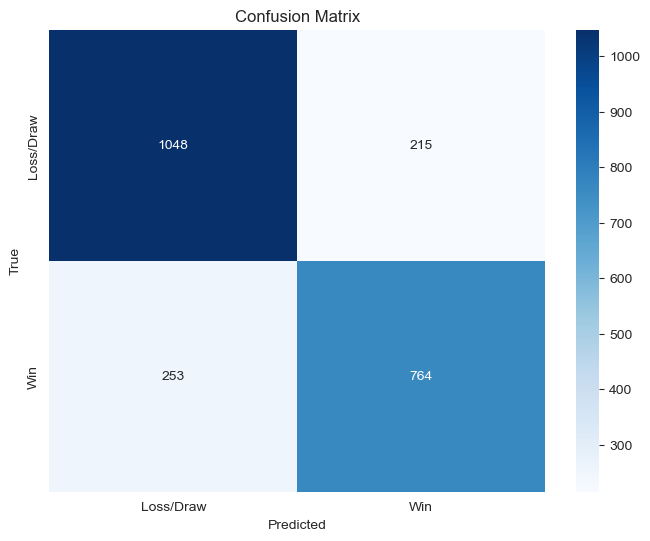

In [20]:
# visualize confusion matrix
conf_matrix = confusion_matrix(test["target"], preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Loss/Draw', 'Win'], yticklabels=['Loss/Draw', 'Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### ROC Curve

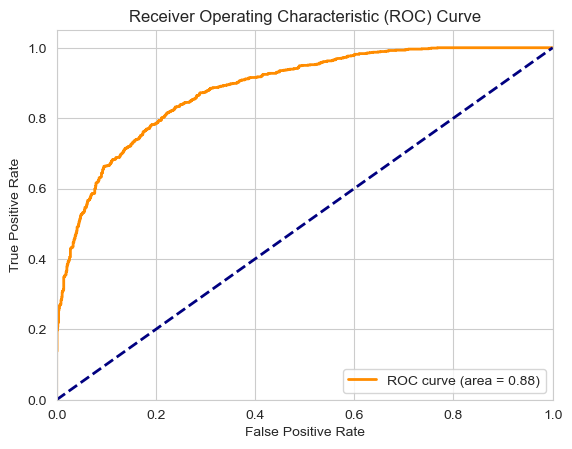

In [21]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC for the stacking classifier
y_score = stacking_clf.predict_proba(test[predictors])[:, 1]
fpr, tpr, _ = roc_curve(test['target'], y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Precision-Recall Curve

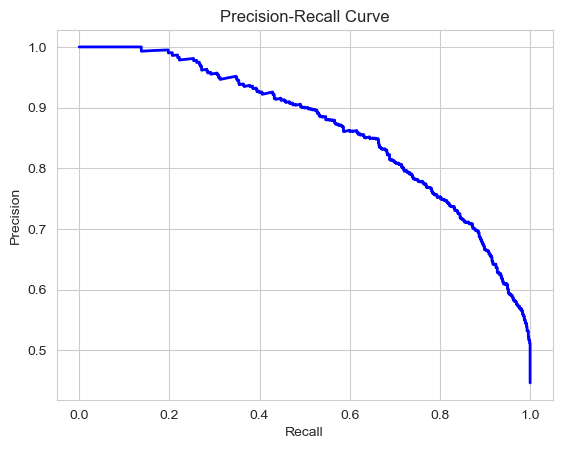

In [30]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(test['target'], y_score)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### Calibration Curve

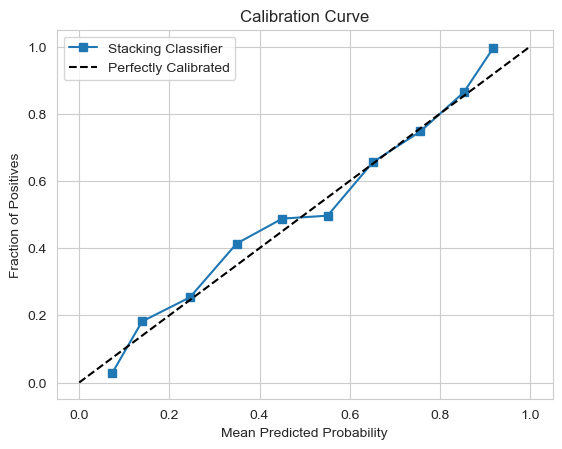

In [32]:
from sklearn.calibration import calibration_curve

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(test['target'], y_score, n_bins=10)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, 's-', label='Stacking Classifier')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

### Distribution of Prediction Errors

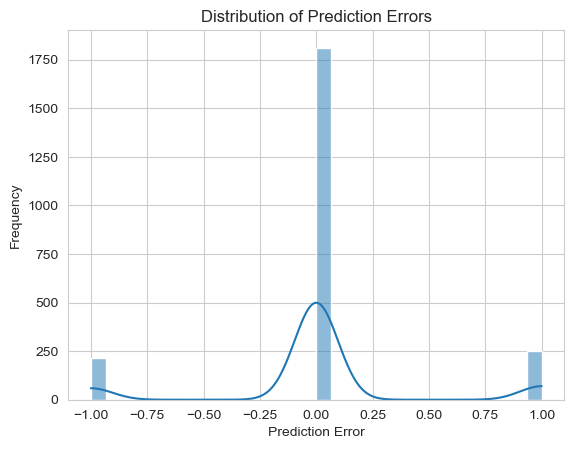

In [33]:
# Calculate prediction errors
errors = test["target"] - preds

# Plot the distribution of errors
plt.figure()
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

### Model Interpretation

In terms of feature importance, the chart below highlights

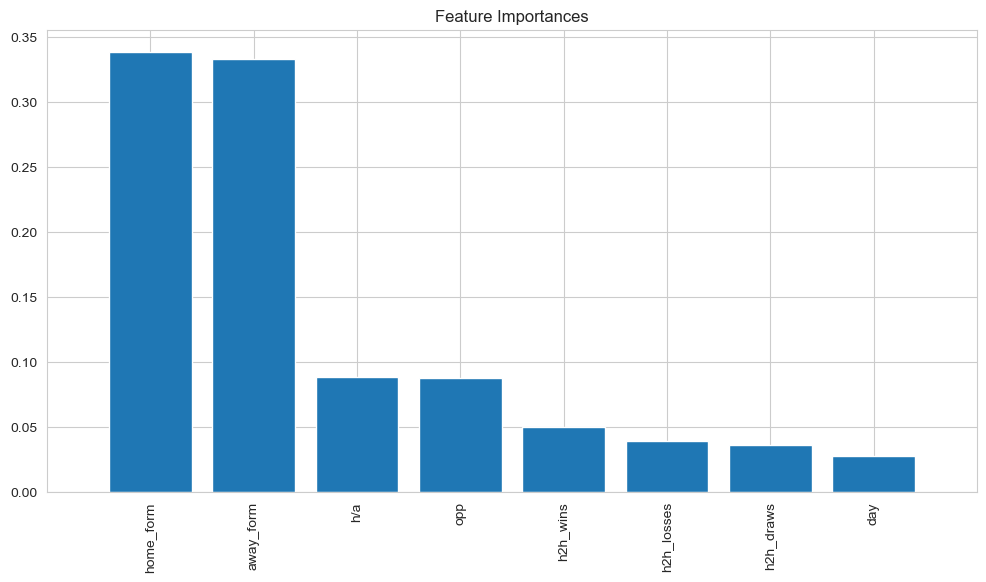

In [22]:
# feature importance
rf_importances = best_rf.feature_importances_
features = predictors
indices = np.argsort(rf_importances)[::-1]

# plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(features)), rf_importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.xlim([-1, len(features)])
plt.show()

## Practical Application

### Predicting Match Outcomes

In [23]:
# function to predict the outcome of a single match
def predict_match(home_team, away_team):
    home_encoder = joblib.load('models/home_encoder.pkl')
    away_encoder = joblib.load('models/away_encoder.pkl')
    home_encoded = home_encoder.transform([home_team])[0]
    away_encoded = away_encoder.transform([away_team])[0]
    
    # ensure 'home_form' and 'away_form' are available for prediction
    if home_team in matches['Home'].values:
        recent_home_form = matches[matches['Home'] == home_team]['home_form'].mean()
    else:
        recent_home_form = 0.5  # neutral val if data unavailable (case for new teams or first entries)
    
    if away_team in matches['Away'].values:
        recent_away_form = matches[matches['Away'] == away_team]['away_form'].mean()
    else:
        recent_away_form = 0.5  # neutral val if data unavailable (case for new teams or first entries)
    
    # retrieve h2h stats dynamically
    past_matches = matches[(matches['Home'] == home_team) & (matches['Away'] == away_team) & (matches['date'] < matches['date'].max())]
    h2h_wins = sum(past_matches['FTR'] == 'H')
    h2h_draws = sum(past_matches['FTR'] == 'D')
    h2h_losses = sum(past_matches['FTR'] == 'A')
    
    # create a df to ensure correct feature names and order
    input_data = pd.DataFrame([[home_encoded, away_encoded, 0, recent_home_form, recent_away_form, h2h_wins, h2h_draws, h2h_losses]], 
                              columns=predictors)
    
    stacking_clf = joblib.load(model_path)
    prediction = stacking_clf.predict(input_data)[0]
    result_mapping = {1: 'Home Win', 0: 'Loss/Draw'}
    return result_mapping[prediction]

In [24]:
# Example usage
home_team = 'Liverpool'
away_team = 'Manchester Utd'
prediction = predict_match(home_team, away_team)

# Detailed Output
print(f"Match Prediction:")
print(f"  Home Team: {home_team}")
print(f"  Away Team: {away_team}")
print(f"  Predicted Outcome for {home_team}: {prediction}")

Match Prediction:
  Home Team: Liverpool
  Away Team: Manchester Utd
  Predicted Outcome for Liverpool: Loss/Draw


## Conclusion